In [ ]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import sys
tf.get_logger().setLevel("ERROR")

#lr_model lr_disc lr_aae lambda_rec lambda_cl lambda_dcl

lr_model = 0.0005
lr_disc = 0.0002
lr_aae = 0.0002
lambda_rec = 1.0
lambda_cl = 0.1
lambda_dcl = 0.0 #float(sys.argv[6])
lambda_mi = 0.001

archi = 2

context = str(lr_model)+"_"+str(lr_disc)+"_"+str(lr_aae)+"_"+str(lambda_rec)+"_"+str(lambda_cl)+"_"+str(lambda_dcl)+"_"+str(archi)

epochs = 200
num_classes = 1622
latent_dim = 15 #previous 10
lambda_corel = tf.constant(lambda_cl)
lambda_decorel = tf.constant(lambda_dcl)
#lambda_adv_var = tf.constant(1.0)
#lambda_var_disc = tf.constant(1.0)
batch_size = 200

In [ ]:
## Build the encoder

encoder_inputs = keras.Input(shape=(28, 28, 1))
if archi == 1: y = layers.Conv2D(latent_dim, 8, activation="relu", strides=1)(encoder_inputs)
elif archi == 2: y = layers.Conv2D(latent_dim*2, 8, activation="relu", strides=1)(encoder_inputs)
y = layers.BatchNormalization()(y)
y = layers.Conv2D(latent_dim, 4, activation="relu", strides=1)(y)
y = layers.BatchNormalization()(y)
y = layers.GlobalMaxPooling2D()(y)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
#z_struct = layers.Dense(latent_dim, activation="sigmoid", name="z_struct")(x)
z_struct = layers.Activation("sigmoid", name="z_struct")(y)
z_var = layers.Dense(latent_dim, activation="linear", name="z_var")(x)
encoder = keras.Model(encoder_inputs, [z_struct, z_var], name="encoder")
encoder.summary()

## Build the decoder
latent_struct = keras.Input(shape=(latent_dim,))
latent_var = keras.Input(shape=(latent_dim,))
x = layers.Concatenate(axis=-1)([latent_struct, latent_var])
x = layers.Dense(7 * 7 * 64, activation="relu")(x)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model([latent_struct, latent_var], decoder_outputs, name="decoder")
decoder.summary()

## Build simple classifiers: target_clf, var_disc
latent = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(latent)
#x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(num_classes, activation="softmax")(x)
target_clf = keras.Model(latent, x, name="target_clf")
target_clf.summary()

latent = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(latent)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(num_classes, activation="softmax")(x)
target_clf_rev = keras.Model(latent, x, name="target_clf_rev")
target_clf_rev.summary()

latent = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(latent)
#x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(1, activation="sigmoid")(x)
var_disc = keras.Model(latent, x, name="var_disc")
var_disc.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_disc))
var_disc.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 14, 14, 32)  128         ['conv2d_2[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv2d (Conv2D)                (None, 21, 21, 30)   1950        ['input_1[0][0]']          

In [ ]:
## Make the model
model_inputs = keras.Input(shape=(28, 28, 1))
z_struct, z_var = encoder(model_inputs)
xx = decoder([z_struct, z_var])
y = target_clf(z_struct)

model = keras.Model(inputs=model_inputs, outputs=[xx, y])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_model))
#model.summary()

var_disc.trainable = False
aae_inputs = keras.Input(shape=(28, 28, 1))
_, z = encoder(aae_inputs)
yv = var_disc(z)
var_aae = keras.Model(aae_inputs, yv)
var_aae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_aae))
#var_aae.summary()

########## Load training data
#################ONLY DO ONCE

from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
'''
#######METRE TOUTES LES IMAGES DANS LE MEME DOSSIER

path = 'drive/MyDrive/projetGan/omniglot'
t1 = '/images_background_full'
t2 = '/images_evaluation_full'
from PIL import Image
import os, os.path

import cv2
def load_data2(dir_path):
    X = []
    y = []
    lang_dict = {}
    classNo = 0
    for alphabet in tqdm(sorted(os.listdir(dir_path))):
        lang_dict[alphabet] = [classNo,None]
        alpha_path = os.path.join(dir_path,alphabet)
        for letter in sorted(os.listdir(alpha_path)):
            cat_images = []
            for img in sorted(os.listdir(os.path.join(alpha_path,letter))):
                img_path = os.path.join(alpha_path,letter,img)
                i = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2GRAY)
                i = cv2.resize(i, dsize=(28,28,1), interpolation=cv2.INTER_CUBIC)
                i.reshape((28,28,1))
                cat_images.append(i)
                y.append(classNo)
            classNo += 1
            X.append(cat_images)
            lang_dict[alphabet][1] = classNo-1
    X = np.array(X)
    y = np.array(y)
    return X, y, lang_dict
classNo = 0
def load_data(dir_path,num_class = num_classes, classNo = classNo):
    X = []
    y = []
    #classNo = 0
    lenClasses = num_classes#####NOMBRE DE CLASSES
    for alphabet in tqdm(sorted(os.listdir(dir_path))):
        alpha_path = os.path.join(dir_path,alphabet)
        for letter in sorted(os.listdir(alpha_path)):
            cat_images = []
            #print(alphabet,'   ---   ',letter)
            for img in sorted(os.listdir(os.path.join(alpha_path,letter))):
                img_path = os.path.join(alpha_path,letter,img)
                i = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2GRAY)
                i = cv2.resize(i, dsize=(28,28), interpolation=cv2.INTER_CUBIC)
                i = i.reshape((28,28,1))
                i = i.astype('float32')
                X.append(i)
                #a = np.zeros((lenClasses))
                #a[classNo] = 1
                y.append(classNo) ###remplacer par a
                #print(classNo)
            classNo += 1
    #print(classNo)
    X = np.array(X)
    y = np.array(y)
    return X, y


image_train_path = path+t1
!ls
image_eval_path = 'drive/MyDrive/projetGan/omniglot/images_evaluation'
!s
xtrain_t, y_train_t = load_data(image_train_path)
print(y_train_t.shape)
#y_train = tf.one_hot(y_train, depth=num_classes)
x_train_t = xtrain.astype("float32") / 255
#print(type(y_train))
#print(type(y_train[0]))
################################### training loop functions #############################
'''

Mounted at /content/drive


'\npath = \'drive/MyDrive/projetGan/omniglot\'\nt1 = \'/images_background_full\'\nt2 = \'/images_evaluation_full\'\nfrom PIL import Image\nimport os, os.path\n\nimport cv2\ndef load_data2(dir_path):\n    X = []\n    y = []\n    lang_dict = {}\n    classNo = 0\n    for alphabet in tqdm(sorted(os.listdir(dir_path))):\n        lang_dict[alphabet] = [classNo,None]\n        alpha_path = os.path.join(dir_path,alphabet)\n        for letter in sorted(os.listdir(alpha_path)):\n            cat_images = []\n            for img in sorted(os.listdir(os.path.join(alpha_path,letter))):\n                img_path = os.path.join(alpha_path,letter,img)\n                i = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2GRAY)\n                i = cv2.resize(i, dsize=(28,28,1), interpolation=cv2.INTER_CUBIC)\n                i.reshape((28,28,1))\n                cat_images.append(i)\n                y.append(classNo)\n            classNo += 1\n            X.append(cat_images)\n            lang_dict[alphab

In [ ]:
!ls drive/MyDrive/projetGan/omniglot

images_background	images_evaluation	x_train_t
images_background_full	images_evaluation_full	y_train_t


In [ ]:
####SI L'ANALYSE EN HAUT A DEJA ETE FAITE, POUR GAGNER DU TEMPS

import pickle
def saveFile(listToSave,FileName):
    with open(FileName,"wb") as f:
        pickle.dump(listToSave, f)
#saveFile(xtrain_t,'drive/MyDrive/projetGan/omniglot/x_train_t')
#saveFile(y_train_t,'drive/MyDrive/projetGan/omniglot/y_train_t')

def loadFile(fileName):
    with open(fileName, "rb") as inputFile:
        e = pickle.load(inputFile)
    return(e)
x_train_t = loadFile('drive/MyDrive/projetGan/omniglot/x_train_t')
y_train_t = loadFile('drive/MyDrive/projetGan/omniglot/y_train_t')

In [ ]:
#print(x_train.shape)
#print(y_train_t.shape)
def expand(x, newShape): 
  xShape = x.shape
  newX = np.zeros((newShape))
  for k in range(60000//x.shape[0]):
    newX[k*xShape[0]:(k+1)*xShape[0]] = x
    last = (k+1)*xShape[0]
  newX[last:] = x[:60000-last]
  return newX
#y_train = tf.one_hot(y_train, depth=num_classes)
x_train_t = x_train_t.astype("float32") / 255

In [ ]:
print(y_train_t[-1])
print(x_train_t.shape)
print(y_train_t.shape)
print(2*5*17)

1622
(32470, 28, 28, 1)
(32470,)
170


In [ ]:
x_train_t,x_test = x_train_t[:25000],x_train_t[25000:]
y_train_t,y_test = y_train_t[:25000],y_train_t[25000:]
#x_train = expand(x_train_t,(32600, 28, 28, 1))
x_train = x_train_t.astype("float32")
#y_train = expand(y_train_t,(32600))
y_train = tf.one_hot(y_train_t, depth=num_classes)
y_train_t = y_train

In [ ]:
print(y_train.shape)

(25000, 1622)


In [ ]:
import matplotlib.pyplot as plt

#plt.imshow(nx[57000].reshape((28,28)))

In [ ]:
@tf.function
def corel_loss_f(z, y):
    zz = z / tf.linalg.norm(z, axis=-1)[:,tf.newaxis]
    sim = zz @ tf.transpose(zz)
    yy = y @ tf.transpose(y)
    diff = tf.reduce_mean(tf.square(sim - yy))
    #print(sim, y, yy)
    #tf.print("sim", sim)
    #tf.print("y", y)
    #tf.print("yy", yy)
    #tf.print("diff", diff)

    return diff

@tf.function
def decorel_loss_f(zs, zv):
    zzs = zs / (0.00000001 + tf.linalg.norm(zs, axis=-1)[:,tf.newaxis])
    sims = zzs @ tf.transpose(zzs)
    sims = sims - tf.eye(sims.shape[0])

    zzv = zv / (0.00000001 + tf.linalg.norm(zv, axis=-1)[:,tf.newaxis])
    simv = zzv @ tf.transpose(zzv)
    simv = 1. - simv

    diff = tf.reduce_mean(tf.square(sims - simv))
    #print(sim, y, yy)
    #tf.print("sim", sim)
    #tf.print("y", y)
    #tf.print("yy", yy)
    #tf.print("diff", diff)

    return diff

@tf.function
def train_step(ones, zeros, x, y):
    #with tf.GradientTape() as tape:
    with tf.GradientTape() as tape, tf.GradientTape() as tape2, tf.GradientTape() as tape3, tf.GradientTape() as tape4:
        z_struct, z_var = encoder(x)
        xx = decoder([z_struct, z_var])
        yy = target_clf(z_struct)
        yyv = target_clf_rev(z_var)

        z_rnd = tf.random.normal(z_var.shape)
        bsize = tf.cast(z_var.shape[0]/2, tf.int32)
        yvp = var_disc(z_rnd[:bsize])
        print(x.shape)
        var_disc_loss_pos = 0.5 * tf.reduce_mean(tf.keras.losses.binary_crossentropy(ones, yvp))
        yvn = var_disc(z_var[:bsize])
        var_disc_loss_neg = 0.5 * tf.reduce_mean(tf.keras.losses.binary_crossentropy(zeros, yvn))
        var_disc_loss = var_disc_loss_pos + var_disc_loss_neg

        yv = var_aae(x[bsize:])

        adv_var_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(ones, yv))

        reconstruct_loss = tf.reduce_mean(tf.square(tf.subtract(x, xx)))
        #corel_loss = corel_loss_f(z_struct, y)
        corel_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y, yy))
        decorel_loss = decorel_loss_f(z_var, y)
        #decorel_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y, yyv))

        #tf.print(tf.reduce_mean(yvp), tf.reduce_mean(yvn), tf.reduce_mean(yv))

        total_loss = lambda_rec * reconstruct_loss + lambda_corel * corel_loss + lambda_decorel * decorel_loss #+ lambda_adv_var * adv_var_loss #+ lambda_var_disc * var_disc_loss

    grads = tape.gradient(total_loss, model.trainable_weights)
    model.optimizer.apply_gradients(zip(grads, model.trainable_weights))

    #grads4 = tape4.gradient(decorel_loss, model.trainable_weights)
    #grads4b = [tf.math.scalar_mul(tf.constant(-1.0, dtype=tf.float32), g) if g is not None else None for g in grads4]
    #model.optimizer.apply_gradients(zip(grads4b, model.trainable_weights))

    var_disc.trainable = True
    grads2 = tape2.gradient(var_disc_loss, var_disc.trainable_weights)
    var_disc.optimizer.apply_gradients(zip(grads2, var_disc.trainable_weights))

    var_disc.trainable = False
    grads3 = tape3.gradient(adv_var_loss, var_aae.trainable_weights)
    var_aae.optimizer.apply_gradients(zip(grads3, var_aae.trainable_weights))

    return total_loss, reconstruct_loss, corel_loss, decorel_loss, adv_var_loss, var_disc_loss

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=25000).batch(batch_size)
zeros = tf.zeros((int(batch_size/2),1))
ones = tf.ones((int(batch_size/2),1))
for epoch in range(epochs):
    total_losses = 0.0
    reconstruct_losses = 0.0
    corel_losses = 0.0
    decorel_losses = 0.0
    adv_var_losses = 0.0
    var_disc_losses = 0.0
    nb = 0.0

    # Iterate over the batches of the dataset.
    for step, (x, y) in enumerate(train_dataset):
        total_loss, reconstruct_loss, corel_loss, decorel_loss, adv_var_loss, var_disc_loss = train_step(ones, zeros, x, y)
        #total_loss, reconstruct_loss, corel_loss, decorel_loss = train_step(epoch, ones, zeros, x, y)
        #tf.print(i, total_loss, reconstruct_loss, corel_loss)

        total_losses = total_losses + total_loss
        reconstruct_losses = reconstruct_losses + reconstruct_loss
        corel_losses = corel_losses + corel_loss
        decorel_losses = decorel_losses + decorel_loss
        adv_var_losses = adv_var_losses + adv_var_loss
        var_disc_losses = var_disc_losses + var_disc_loss
        nb = nb + 1.0

    print("####", epoch, tf.divide(total_losses, nb).numpy(), tf.divide(reconstruct_losses, nb).numpy(), tf.divide(corel_losses, nb).numpy(), tf.divide(decorel_losses, nb).numpy(), tf.divide(adv_var_losses, nb).numpy(), tf.divide(var_disc_losses, nb).numpy(), "__", context)

if epochs > 0: model.save_weights("weights_"+context+".h5")
else: model.load_weights("weights_"+context+".h5")

########## reload complete dataset
'''
(x_train_t, y_train_t), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train_t = np.expand_dims(x_train_t, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255
y_train_t_oh = keras.utils.to_categorical(y_train_t, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
'''




(200, 28, 28, 1)
#### 0 0.742089 0.028868504 7.132201 1.0043719 0.7094842 0.6874529 __ 0.0005_0.0002_0.0002_1.0_0.1_0.0_2
#### 1 0.74222666 0.029008823 7.1321797 1.0272044 0.70847154 0.6882192 __ 0.0005_0.0002_0.0002_1.0_0.1_0.0_2
#### 2 0.7419645 0.028745852 7.1321883 1.0363771 0.70065427 0.68461376 __ 0.0005_0.0002_0.0002_1.0_0.1_0.0_2
#### 3 0.7419934 0.028775219 7.1321807 1.0392581 0.7096614 0.68574053 __ 0.0005_0.0002_0.0002_1.0_0.1_0.0_2
#### 4 0.7420975 0.028880673 7.132167 1.0202377 0.70310676 0.68693817 __ 0.0005_0.0002_0.0002_1.0_0.1_0.0_2
#### 5 0.7421456 0.028928138 7.132175 1.0183493 0.70764595 0.6875632 __ 0.0005_0.0002_0.0002_1.0_0.1_0.0_2
#### 6 0.7422701 0.029052231 7.1321774 1.0109414 0.70139486 0.68965775 __ 0.0005_0.0002_0.0002_1.0_0.1_0.0_2
#### 7 0.74220634 0.028987868 7.1321826 1.0161662 0.7020566 0.68767273 __ 0.0005_0.0002_0.0002_1.0_0.1_0.0_2
#### 8 0.7422137 0.028997757 7.1321573 1.0269569 0.70657134 0.6881432 __ 0.0005_0.0002_0.0002_1.0_0.1_0.0_2
#### 9 0.74

'\n(x_train_t, y_train_t), (x_test, y_test) = keras.datasets.mnist.load_data()\nx_train_t = np.expand_dims(x_train_t, -1).astype("float32") / 255\nx_test = np.expand_dims(x_test, -1).astype("float32") / 255\ny_train_t_oh = keras.utils.to_categorical(y_train_t, num_classes)\ny_test = keras.utils.to_categorical(y_test, num_classes)\n'

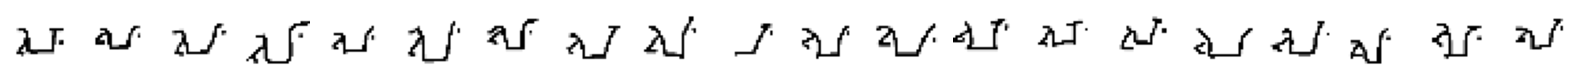

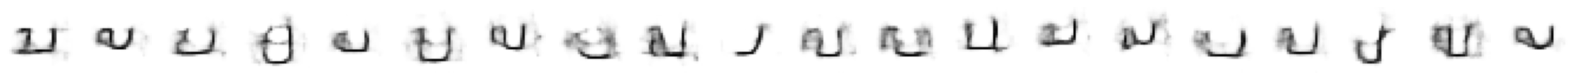

In [ ]:
def show_images(images, name, rows = 1):
    n_images = len(images)
    fig = plt.figure(figsize=(28,28))
    n = 1
    for image in images:
        a = fig.add_subplot(rows, np.ceil(n_images/float(rows)), n)
        n += 1
        plt.axis('off')
        img = image[:,:,0]
        if img.ndim == 2:
            plt.gray()
        plt.imshow(img)
    #fig.savefig("images/"+name+".png")

#print("Original")
show_images(x_train[:20], "original_"+context, 1)
#print("Reconstructed")
show_images(model.predict(x_train[:20])[0], "reconstructed_"+context, 1)

In [ ]:
def show_images(images, name, rows = 1):
    n_images = len(images)
    fig = plt.figure(figsize=(28,28))
    n = 1
    for image in images:
        a = fig.add_subplot(rows, np.ceil(n_images/float(rows)), n)
        n += 1
        plt.axis('off')
        img = image[:,:,0]
        if img.ndim == 2:
            plt.gray()
        plt.imshow(img)
    #fig.savefig("images/"+name+".png")

In [ ]:
### get prototype per class : mean from latent space
'''
list_protos = []
for c in range(num_classes):
  #print(y_train == 0)
  x_c = x_train_t[y_train_t == c]
  zc_structs, zc_vars = encoder(x_c)
  #print("Norm struct:", (tf.linalg.norm(zc_structs)/len(zc_structs)).numpy(), "Norm var:", (tf.linalg.norm(zc_vars)/len(zc_vars)).numpy())
  zc_struct_mean = tf.reshape(tf.reduce_mean(zc_structs, axis=0), (1, latent_dim))
  zc_var_mean = tf.reshape(tf.reduce_mean(zc_vars, axis=0), (1, latent_dim))
  zc_struct_std = tf.reduce_mean(tf.math.reduce_std(zc_structs, axis=0))
  zc_var_std = tf.reduce_mean(tf.math.reduce_std(zc_vars, axis=0))
  #print("zc_struct_std:", zc_struct_std.numpy(), "zc_var_std:", zc_var_std.numpy())
  #zc_var_mean = tf.zeros_like(zc_struct_mean) + tf.linalg.norm(zc_vars)/len(zc_vars)
  xx_c = decoder([zc_struct_mean, zc_var_mean])
  #print(xx_c.shape)
  list_protos.append(xx_c[0])

show_images(list_protos, "protos_"+context, 1)


list_protos = []
for c in range(num_classes):
  x_c = x_train_t[y_train_t == c]
  zc_structs, zc_vars = encoder(x_c)
  zc_struct_mean = tf.reshape(tf.reduce_mean(zc_structs, axis=0), (1, latent_dim))
  zc_var_mean = tf.reshape(tf.reduce_mean(zc_vars, axis=0), (1, latent_dim))
  zc_var_mean = tf.zeros_like(zc_var_mean) #+ 0.5 #+ tf.linalg.norm(zc_vars)/len(zc_vars)
  xx_c = decoder([zc_struct_mean, zc_var_mean])
  list_protos.append(xx_c[0])

show_images(list_protos, "protos_struct_"+context, 1)


list_protos = []
for c in range(num_classes):
  x_c = x_train_t[y_train_t == c]
  zc_structs, zc_vars = encoder(x_c)
  zc_struct_mean = tf.reshape(tf.reduce_mean(zc_structs, axis=0), (1, latent_dim))
  zc_struct_mean = tf.zeros_like(zc_struct_mean) + 0.5 #+ tf.linalg.norm(zc_structs)/len(zc_structs)
  zc_var_mean = tf.reshape(tf.reduce_mean(zc_vars, axis=0), (1, latent_dim))
  xx_c = decoder([zc_struct_mean, zc_var_mean])
  list_protos.append(xx_c[0])

show_images(list_protos, 'protos_var_'+context, 1)
'''

'\nlist_protos = []\nfor c in range(num_classes):\n  #print(y_train == 0)\n  x_c = x_train_t[y_train_t == c]\n  zc_structs, zc_vars = encoder(x_c)\n  #print("Norm struct:", (tf.linalg.norm(zc_structs)/len(zc_structs)).numpy(), "Norm var:", (tf.linalg.norm(zc_vars)/len(zc_vars)).numpy())\n  zc_struct_mean = tf.reshape(tf.reduce_mean(zc_structs, axis=0), (1, latent_dim))\n  zc_var_mean = tf.reshape(tf.reduce_mean(zc_vars, axis=0), (1, latent_dim))\n  zc_struct_std = tf.reduce_mean(tf.math.reduce_std(zc_structs, axis=0))\n  zc_var_std = tf.reduce_mean(tf.math.reduce_std(zc_vars, axis=0))\n  #print("zc_struct_std:", zc_struct_std.numpy(), "zc_var_std:", zc_var_std.numpy())\n  #zc_var_mean = tf.zeros_like(zc_struct_mean) + tf.linalg.norm(zc_vars)/len(zc_vars)\n  xx_c = decoder([zc_struct_mean, zc_var_mean])\n  #print(xx_c.shape)\n  list_protos.append(xx_c[0])\n\nshow_images(list_protos, "protos_"+context, 1)\n\n\nlist_protos = []\nfor c in range(num_classes):\n  x_c = x_train_t[y_train_t ==

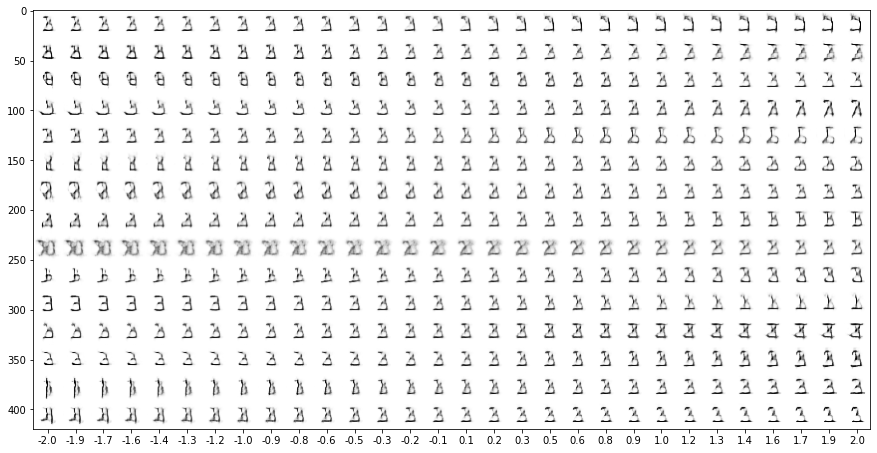

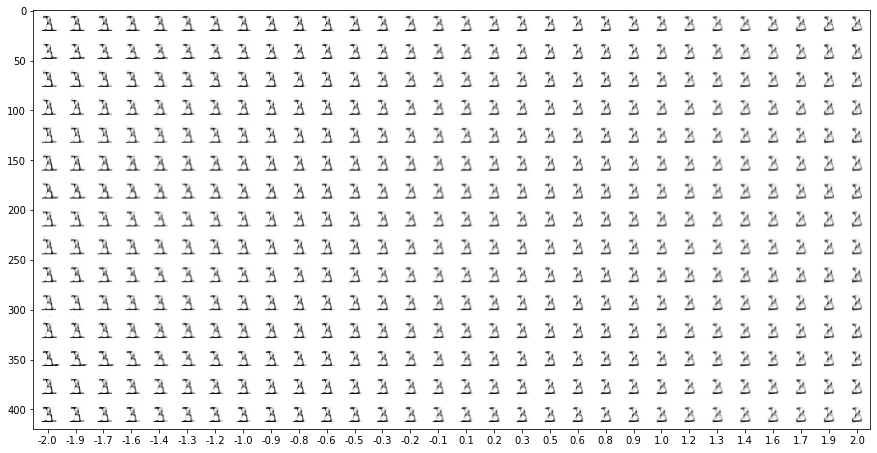

In [ ]:
###### traversals ######

def plot_traversals(encoder, decoder, data, labels, n=30, figsize=15, mode=1):
    # display a latent traversal for a class of digits

    z_struct, z_var  = encoder.predict(data[20][np.newaxis, :,:,:])

    digit_size = 28
    scale = 1.
    figure = np.zeros((digit_size * latent_dim, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-2, 2, n)

    z_samples = []
    for i in range(latent_dim):
        for j, xi in enumerate(grid_x):
            if mode == 1: z_z = tf.squeeze(tf.identity(z_var)).numpy()
            else: z_z = tf.squeeze(tf.identity(z_struct)).numpy()
            z_z[i] = xi
            z_samples.append(z_z)
    z_zs = np.array(z_samples)
    if mode == 1:
      z_structs = tf.repeat(z_struct, len(z_zs), axis=0)
      x_decoded = decoder.predict([z_structs, z_zs])
    else:
      z_vars = tf.repeat(z_var, len(z_zs), axis=0)
      x_decoded = decoder.predict([z_zs, z_vars])
    ii = 0
    for i in range(latent_dim):
         for j, xi in enumerate(grid_x):
            digit = x_decoded[ii].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit
            ii += 1

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    #sample_range_y = np.round(range(0,9), 1)
    plt.xticks(pixel_range, sample_range_x)
    #plt.yticks(pixel_range, sample_range_y)
    plt.imshow(figure, cmap="Greys_r")
    #if mode == 1: plt.savefig('images/traversals_zvars_'+context+'.png')
    #else: plt.savefig('images/traversals_zstructs_'+context+'.png')

plot_traversals(encoder, decoder, x_train_t, y_train_t, mode=1)
plot_traversals(encoder, decoder, x_train_t, y_train_t, mode=2)


In [ ]:
######## 2D plots ######

def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_struct, z_var = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_struct[:, 0], z_struct[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title("z_struct latent space")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    #plt.savefig('images/plot_z_struct_clusters_'+context+'.png')

    plt.figure(figsize=(12, 10))
    plt.scatter(z_var[:, 0], z_var[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title("z_var latent space")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    #plt.savefig('images/plot_z_var_clusters_'+context+'.png')

if latent_dim == 2:
  (x_train_tt, y_train_tt), (x_test, y_test) = keras.datasets.mnist.load_data()
  x_train_tt = np.expand_dims(x_train_tt, -1).astype("float32") / 255
  plot_label_clusters(encoder, x_train_tt, y_train_tt)

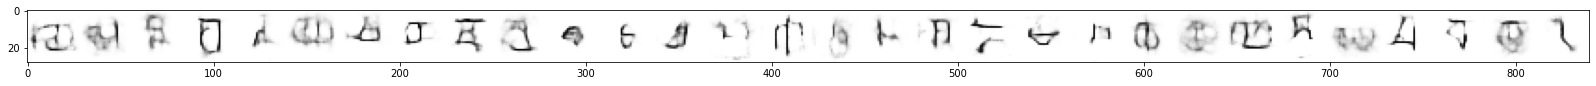

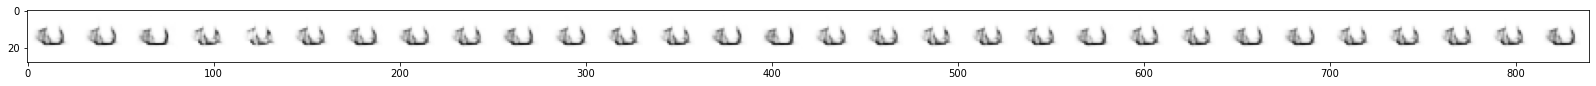

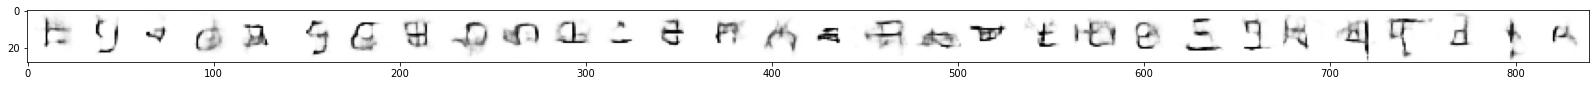

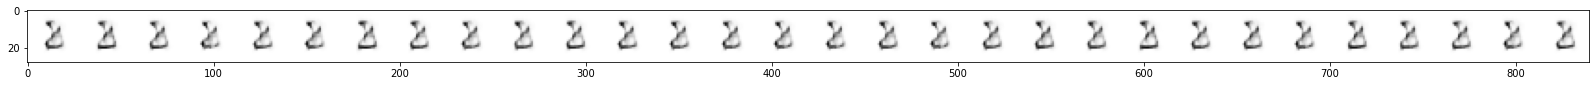

In [ ]:
####################### generate and save random images #############@@
def plot_randoms(encoder, decoder, data, labels, n=30, figsize=28, mode=1, idx=20):
    # display a latent traversal for a class of digits

    z_struct, z_var  = encoder.predict(data[idx][np.newaxis, :,:,:])
    _, zc_vars = encoder(x_train[0:40000:2])
    zc_var_mean = tf.reshape(tf.reduce_mean(zc_vars, axis=0), (1, latent_dim))
    zc_var_std = tf.reshape(tf.math.reduce_std(zc_vars, axis=0), (1, latent_dim))

    digit_size = 28
    scale = 1.
    figure = np.zeros((digit_size, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space

    z_samples = []
    if mode == 1:
        for i in range(n):
          z_rnd = np.squeeze(np.random.normal(loc=zc_var_mean, scale=zc_var_std, size=z_var.shape))
          z_samples.append(z_rnd)
        z_zs = np.array(z_samples)
        z_structs = tf.repeat(z_struct, len(z_zs), axis=0)
        x_decoded = decoder.predict([z_structs, z_zs])
    else:
        for i in range(n):
          z_rnd = np.squeeze(np.random.uniform(low=0, high=1, size=z_var.shape))
          z_samples.append(z_rnd)
        z_zs = np.array(z_samples)
        z_vars = tf.repeat(z_var, len(z_zs), axis=0)
        x_decoded = decoder.predict([z_zs, z_vars])
    ii = 0
    i = 0
    for j in range(n):
            digit = x_decoded[j].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit
            ii += 1

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    #sample_range_x = np.round(grid_x, 1)
    #sample_range_y = np.round(range(0,9), 1)
    #plt.xticks(pixel_range, sample_range_x)
    #plt.yticks(pixel_range, sample_range_y)
    plt.imshow(figure, cmap="Greys_r")
    #if mode == 1: plt.savefig('images/latent_random_var_'+str(idx)+"_"+context+'.png')
    #else: plt.savefig('images/latent_random_struct_'+str(idx)+"_"+context+'.png')

plot_randoms(encoder, decoder, x_train_t, y_train_t, mode=1, idx=4)
plot_randoms(encoder, decoder, x_train_t, y_train_t, mode=2, idx=4)
plot_randoms(encoder, decoder, x_train_t, y_train_t, mode=1, idx=20)
plot_randoms(encoder, decoder, x_train_t, y_train_t, mode=2, idx=20)


In [ ]:
######################### evaluate custom metric 1

# load pretrained model
#mnist_cnn = load_model("mnist_cnn_pretrained.h5")
#score = mnist_cnn.evaluate(x_test, y_test)
'''
# get training set statistics
_, zc_vars = encoder(x_train[0:50000:2])
zc_var_mean = tf.reshape(tf.reduce_mean(zc_vars, axis=0), (1, latent_dim))
zc_var_std = tf.reshape(tf.math.reduce_std(zc_vars, axis=0), (1, latent_dim))

print("encode few shot examples")
target = 9
K = 3
x_generated = []
for idx in range(K):
  one_shot_nine = x_train_t[y_train_t == target][idx:idx+1]
  z_struct, z_var  = encoder.predict(one_shot_nine) #x_train_t[idx][np.newaxis, :,:,:])

  print("sample random z_vars")
  nb_augment = int(6000/K)
  z_samples = []
  for i in range(nb_augment):
    z_rnd = np.squeeze(np.random.normal(loc=zc_var_mean, scale=zc_var_std, size=z_var.shape))
    z_samples.append(z_rnd)
  z_zs = np.array(z_samples)

  print("generate new examples")
  z_structs = tf.repeat(z_struct, len(z_zs), axis=0)
  x_generated.append( decoder.predict([z_structs, z_zs]))

x_decoded = np.concatenate(x_generated, axis=0)
np.random.shuffle(x_decoded)
#x_decoded = decoder.predict([z_zs, z_zs])
mins=tf.reduce_min(x_decoded, axis=[1,2,3])[:,tf.newaxis, tf.newaxis, tf.newaxis]
maxs=tf.reduce_max(x_decoded, axis=[1,2,3])[:,tf.newaxis, tf.newaxis, tf.newaxis]
x_decoded = (x_decoded - mins)/(maxs-mins)
x_decoded = tf.where(tf.less(x_decoded, 0.1), 0., x_decoded)
x_decoded = tf.where(tf.greater(x_decoded, 0.8), 1., x_decoded)

print("save 100 images")
nines = np.array(x_decoded[:100]*255, dtype=np.uint8)
show_images(nines, "nines", 10)

print("metric 1")
nines = np.ones((K*nb_augment,))*target
y_nines = keras.utils.to_categorical(nines, num_classes)
score1 = mnist_cnn.evaluate(x_decoded, y_nines)

######################## evaluate custom metric 2

print("metric 2")
mnist_cnn = load_model("mnist_cnn_initialized.h5") # load untrained model
x_train_t2 = x_train_t[y_train_t != target]
y_train_t2 = y_train_t[y_train_t != target]
y_train_t2 = keras.utils.to_categorical(y_train_t2, num_classes)

x_train_t2 = np.concatenate([x_train_t2, x_decoded], axis=0)
y_train_t2 = np.concatenate([y_train_t2, y_nines], axis=0)
indices = np.arange(x_train_t2.shape[0])
np.random.shuffle(indices)
x_train_t2 = x_train_t2[indices]
y_train_t2 = y_train_t2[indices]

mnist_cnn.fit(x_train_t2, y_train_t2, batch_size=128, epochs=15, verbose=0)
score2 = mnist_cnn.evaluate(x_test, y_test)

try:
    print("####", epoch, tf.divide(total_losses, nb).numpy(), tf.divide(reconstruct_losses, nb).numpy(), tf.divide(corel_losses, nb).numpy(), tf.divide(decorel_losses, nb).numpy(), tf.divide(adv_var_losses, nb).numpy(), tf.divide(var_disc_losses, nb).numpy(), "__", context, np.round(score1[1], 3), np.round(score2[1], 3))
except:
    print("####", context, np.round(score1[1], 3), np.round(score2[1], 3))
  '''


'\n# get training set statistics\n_, zc_vars = encoder(x_train[0:50000:2])\nzc_var_mean = tf.reshape(tf.reduce_mean(zc_vars, axis=0), (1, latent_dim))\nzc_var_std = tf.reshape(tf.math.reduce_std(zc_vars, axis=0), (1, latent_dim))\n\nprint("encode few shot examples")\ntarget = 9\nK = 3\nx_generated = []\nfor idx in range(K):\n  one_shot_nine = x_train_t[y_train_t == target][idx:idx+1]\n  z_struct, z_var  = encoder.predict(one_shot_nine) #x_train_t[idx][np.newaxis, :,:,:])\n\n  print("sample random z_vars")\n  nb_augment = int(6000/K)\n  z_samples = []\n  for i in range(nb_augment):\n    z_rnd = np.squeeze(np.random.normal(loc=zc_var_mean, scale=zc_var_std, size=z_var.shape))\n    z_samples.append(z_rnd)\n  z_zs = np.array(z_samples)\n\n  print("generate new examples")\n  z_structs = tf.repeat(z_struct, len(z_zs), axis=0)\n  x_generated.append( decoder.predict([z_structs, z_zs]))\n\nx_decoded = np.concatenate(x_generated, axis=0)\nnp.random.shuffle(x_decoded)\n#x_decoded = decoder.predic

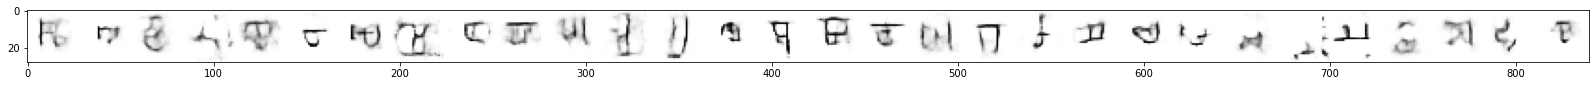

In [ ]:
plot_randoms(encoder, decoder, x_test, y_test, mode=1, idx=4)

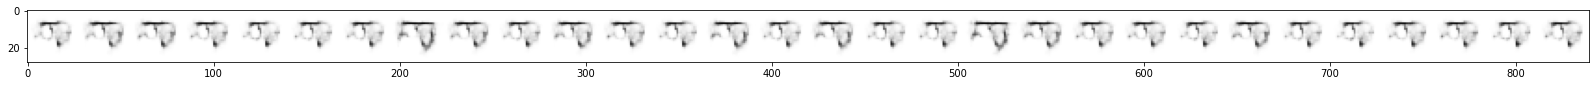

In [ ]:
plot_randoms(encoder, decoder, x_test, y_test, mode=2, idx=4)

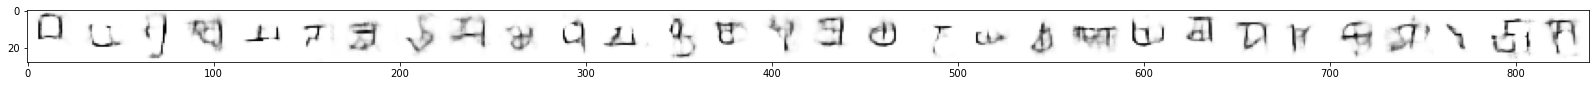

In [ ]:
plot_randoms(encoder, decoder, x_test, y_test, mode=1, idx=20)

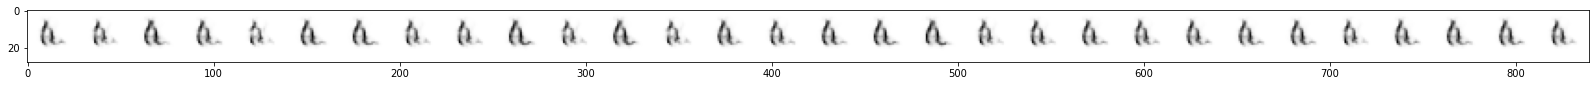

In [ ]:
plot_randoms(encoder, decoder, x_test, y_test, mode=2, idx=20)